# Predicting Bicycle Traffic

In [4]:
import numpy as np
import pandas as pd

bicycle_counts = pd.read_csv('fremont_hourly.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('bicycle_weather.csv', index_col='DATE', parse_dates=True)

In [5]:
#Total daily bicycle traffic
daily = bicycle_counts.resample('d', how='sum')
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']]

Total daily bicycle traffic


/Users/jessica/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  


In [8]:
#Days of the week
days = ['Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [10]:
#Holidays
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

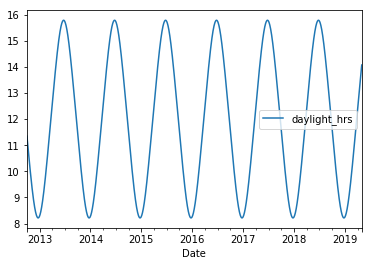

In [13]:
#Daylight hours
import matplotlib.pyplot as plt

def hours_of_daylight(date, axis=23.44, latitude=47.61):
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude)) 
        * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.35)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()

In [17]:
# Temperature, Total precipitation & Indicator whether day is dry

# temp are in 1/10 deg C, conver to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp(C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm, convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp(C)', 'dry day']])

In [18]:
# Counter that updates from day 1 & measure how many years have passed.
daily['annual'] = (daily.index - daily.index[0]).days / 365

In [19]:
daily.head()

,Total,Mon,Tue,Wed,Thr,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp(C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.346075,0.0,0.01335,1.0,0.000000
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.287752,0.0,0.01360,1.0,0.002740
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.229531,0.0,0.01530,1.0,0.005479
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.171422,0.0,0.01585,1.0,0.008219
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.113434,0.0,0.01585,1.0,0.010959


In [24]:
daily.dropna(axis=0, how='any', inplace=True)
column_names = ['Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp(C)', 'annual']
X = daily[column_names]
y = daily['Total']

from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

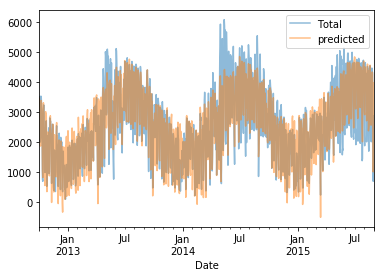

In [25]:
# Compare total and predicted bicycle traffic visually
daily[['Total', 'predicted']].plot(alpha=0.5)

In [26]:
# Coefficient of Linear model to estimate how much each feature
# contributes to daily bicycle count
coeff = pd.Series(model.coef_, index=X.columns)
coeff

Mon             4.957081e+02
Tue             6.006126e+02
Wed             5.828249e+02
Thr             4.726146e+02
Fri             1.682211e+02
Sat            -1.113026e+03
Sun            -1.143269e+03
holiday        -1.188861e+03
daylight_hrs    1.308552e+02
PRCP           -4.288345e+07
dry day         5.467445e+02
Temp(C)         6.393903e+04
annual          2.824638e+01
dtype: float64

In [27]:
# To interpret little easier lets measure it with uncertainity
# using bootstrap resampling of the data
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X,y)).coef_
             for i in range(1000)], 0)

In [29]:
print(pd.DataFrame({'effect': coeff.round(0),
                   'error': err.round(0)}))

                  effect      error
Mon                496.0       87.0
Tue                601.0       84.0
Wed                583.0       83.0
Thr                473.0       86.0
Fri                168.0       82.0
Sat              -1113.0       80.0
Sun              -1143.0       84.0
holiday          -1189.0      163.0
daylight_hrs       131.0        9.0
PRCP         -42883454.0  4034734.0
dry day            547.0       33.0
Temp(C)          63939.0     3682.0
annual              28.0       18.0


# Conclusion

From the above data, we can see that there is relatively stable trend in weekly baseline - there are more riders on weekdays than on weekends. We can also observe that for each additional hour of daylight ~ 131 +- 9 more people choose to ride, a dry day means an average of 547 +- 33 more riders, each inch of precipitation means more people to leave their bike at home. Finally, we see a modest increase of 28 +- 18 new daily riders each year.